In [1]:
import pandas as pd 

import statsmodels.api as sm 

import seaborn as sns 

import numpy as np 

import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('/Users/jack/Desktop/Cleaned Data New/Prov/pre_covid_providers.csv',
            index_col='FILEDATE',
            parse_dates=['FILEDATE']).infer_objects()

df.index = pd.to_datetime(df.index,format='mixed',yearfirst=True)

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_75234/3289199034.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/jack/Desktop/Cleaned Data New/Prov/pre_covid_providers.csv',


In [3]:
plt.style.use('fivethirtyeight')

#drop col OLDSURVEY, 40kNA 
df = df.drop('OLDSURVEY',axis=1).copy()


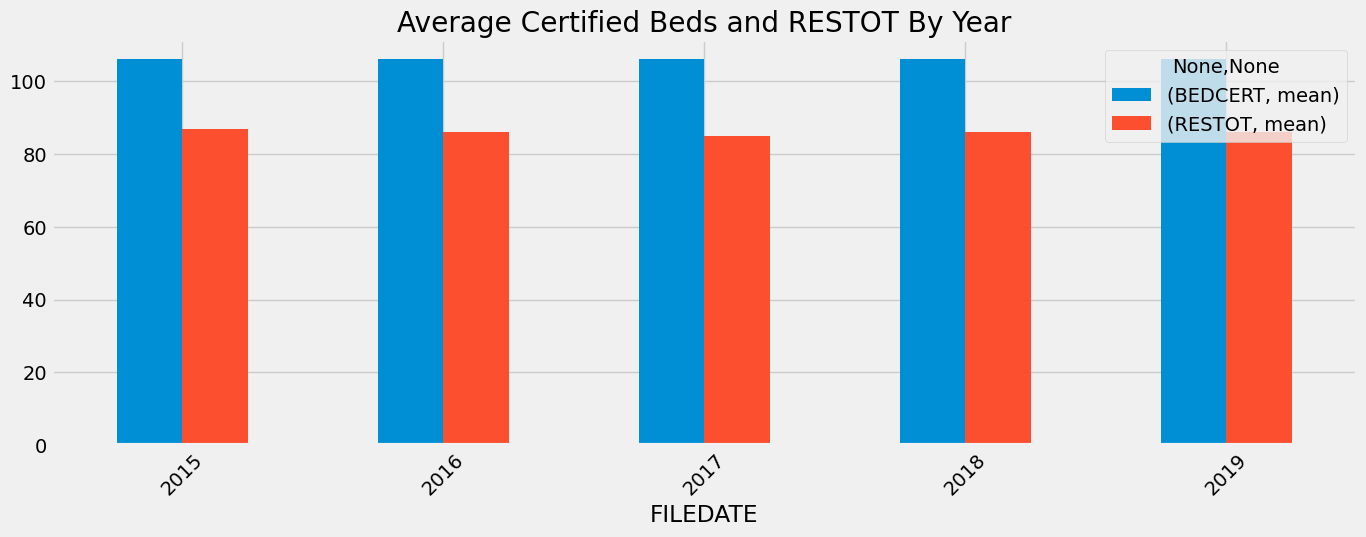

In [4]:
fig = df.resample('a')[['BEDCERT','RESTOT']]\
    .agg(['mean']).round().plot(kind='bar',
                                title='Average Certified Beds and RESTOT By Year',
                                figsize=(15,5))
    
fig.set_xticklabels(labels=['2015','2016','2017','2018','2019'],
                    rotation=45)

plt.show()

Read in data dictionary for easy viewing 

In [5]:
data_dict = pd.read_excel('/Users/jack/Desktop/ManhattanProject/DataDictionary_other_datasets.xlsx',sheet_name=1)

In [6]:
data_dict = data_dict.rename(columns={'Variable Name (column headers on CSV Downloadable files)':'var',
                                      'Label (column headers on CSV Display files)':'label'})

data_dict.set_index('var',inplace=True)

In [7]:
#splitting ownership to get a better view of ownership and operation type 

df = df.assign(ownership = df.OWNERSHIP.str.split('-',expand=True)[0],
          op_type = df.OWNERSHIP.str.split('-',expand=True)[1]).drop('OWNERSHIP',axis=1)

Building "sum" pivots of incidents, complaints, certified beds etc. 

In [8]:
cats = ['STATE','ownership','CERTIFICATION']

total_pivs = {}

for col in cats: 
    
    piv = df.groupby(col)[['BEDCERT','RESTOT','INCIDENT_CNT','CMPLNT_CNT','FINE_CNT']].sum()
    
    total_pivs[col] = piv.sort_values(by=['BEDCERT','RESTOT'],ascending=[False,False])

In [9]:
cats = ['STATE','ownership','CERTIFICATION']

rated_pivs = {}

for col in cats: 
    
    piv = df.groupby(col)[['OVERALL_RATING','SURVEY_RATING','QUALITY_RATING','STAFFING_RATING']].mean()
    
    rated_pivs[col] = piv.sort_values(by=['OVERALL_RATING'],ascending=False)

Text(0.5, 1.0, 'Correlation Matrix of Provider Info')

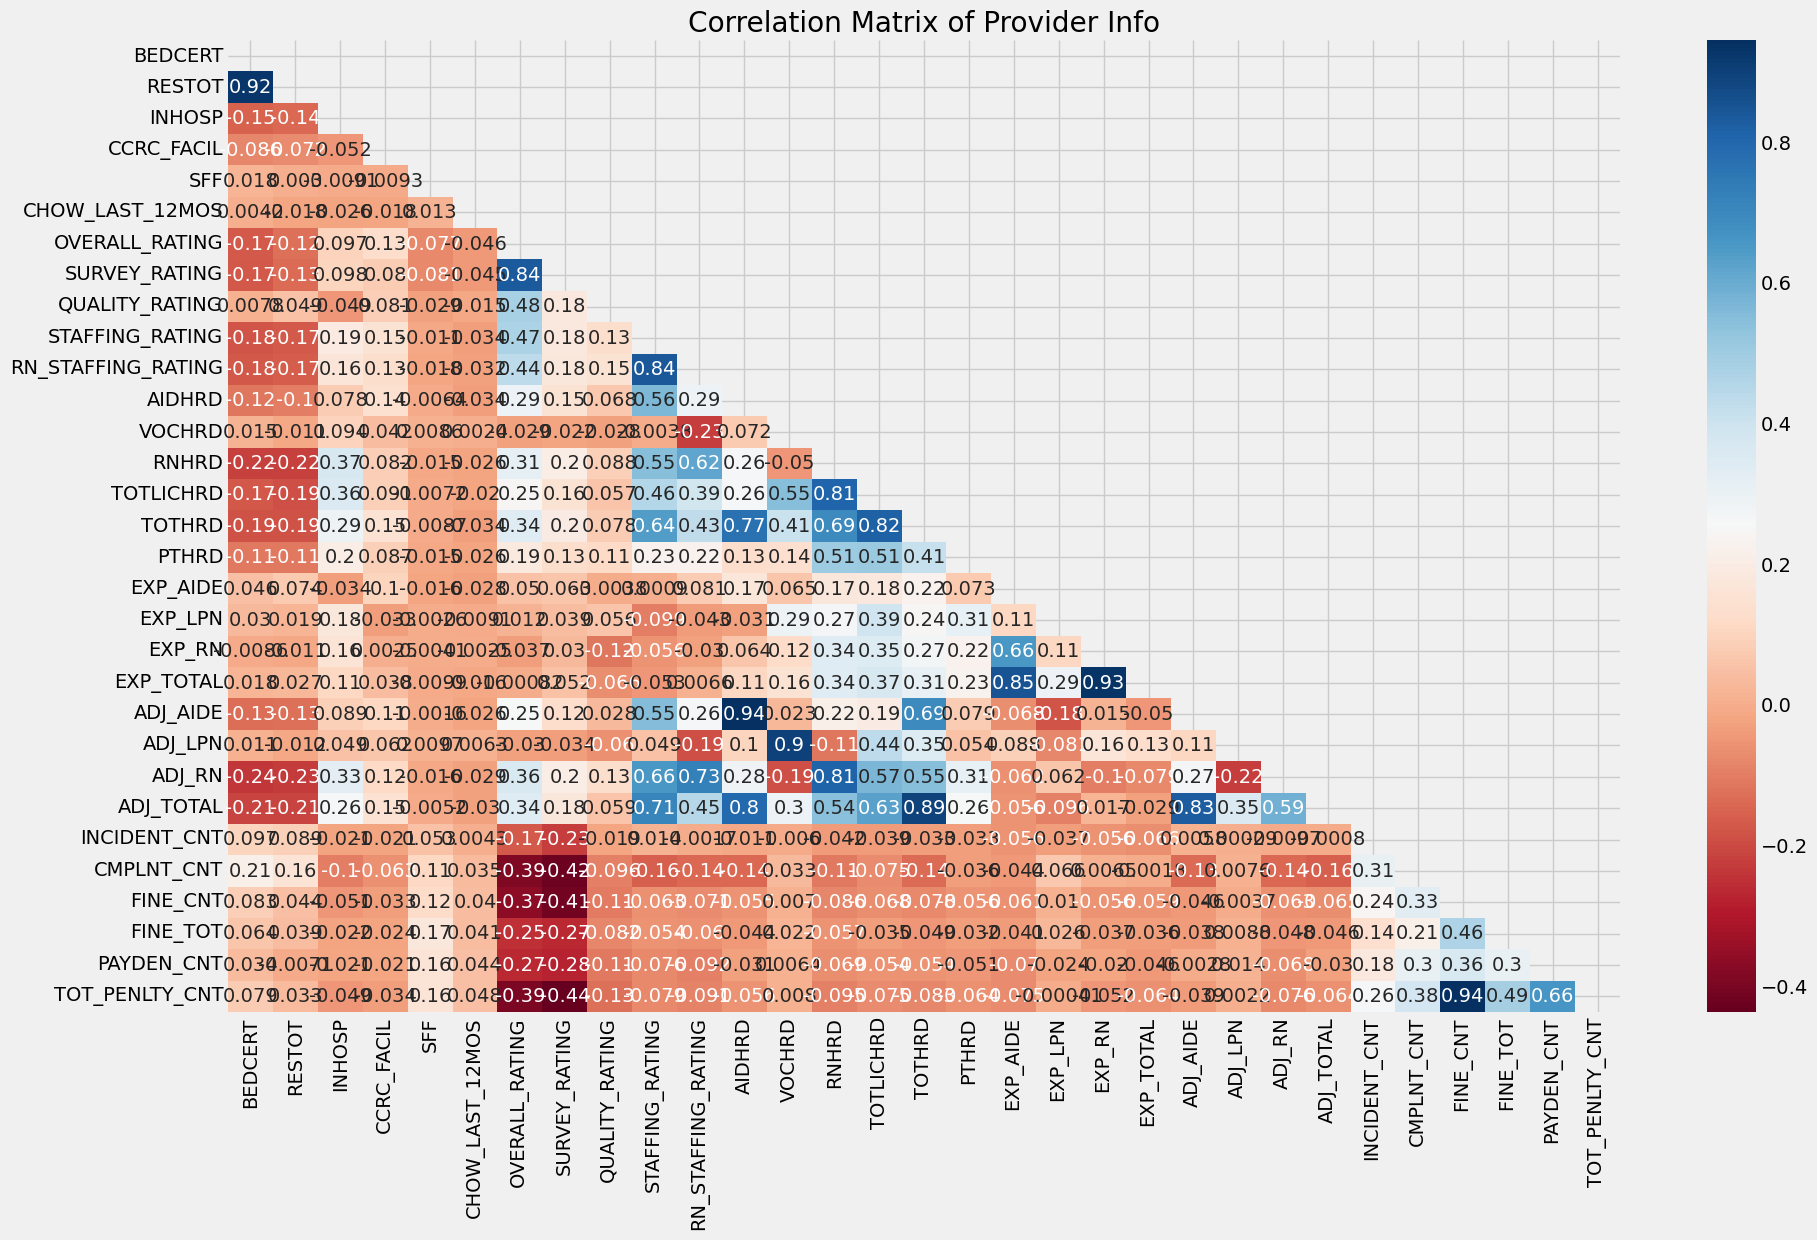

In [10]:
corr = df.select_dtypes(include=[int,float]).corr(method='pearson')

mask = np.triu(np.ones_like(corr))


#corr map 
plt.figure(figsize=(20,12))
sns.heatmap(corr, mask=mask,cmap='RdBu',annot=True)

plt.title('Correlation Matrix of Provider Info')

In [11]:
import plotly.express as px 

px.scatter(df,x='BEDCERT',
           y='RESTOT',
           color='OVERALL_RATING',
           title='Avg Daily Residents v Certified Beds (Pre Covid)')

In [12]:
ratings_by_state = rated_pivs['STATE'].round(2)

ownership_rating = rated_pivs['ownership'].round(2)

owned_pivs = total_pivs['ownership']

In [13]:
top_5_comp = total_pivs['STATE'].sort_values(by=['INCIDENT_CNT','CMPLNT_CNT'],ascending=[False,False])[:5]

comp_df = df[df.STATE.isin(top_5_comp.index.tolist())]

comp_df.PARTICIPATION_DATE = pd.to_datetime(comp_df.PARTICIPATION_DATE,format='mixed')

comp_df = comp_df.assign(start_year = comp_df.PARTICIPATION_DATE.dt.year)


comp_df.groupby('STATE').agg({'OVERALL_RATING':'mean','INCIDENT_CNT':'sum','CMPLNT_CNT':'sum'})

#texas has a very poor overall rating and is a higher volume state

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_75234/788300570.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



OVERALL_RATING  INCIDENT_CNT  CMPLNT_CNT
STATE                                          
CA           3.580956         20782       32319
MD           3.322064          6201        7794
MI           3.429226         11157       22526
TX           2.672660          6875       23270
WA           3.574766          5970        6312

Text(0.5, 1.0, 'Are Certain Ownership Types Correlated to Incidents, or complaints?')

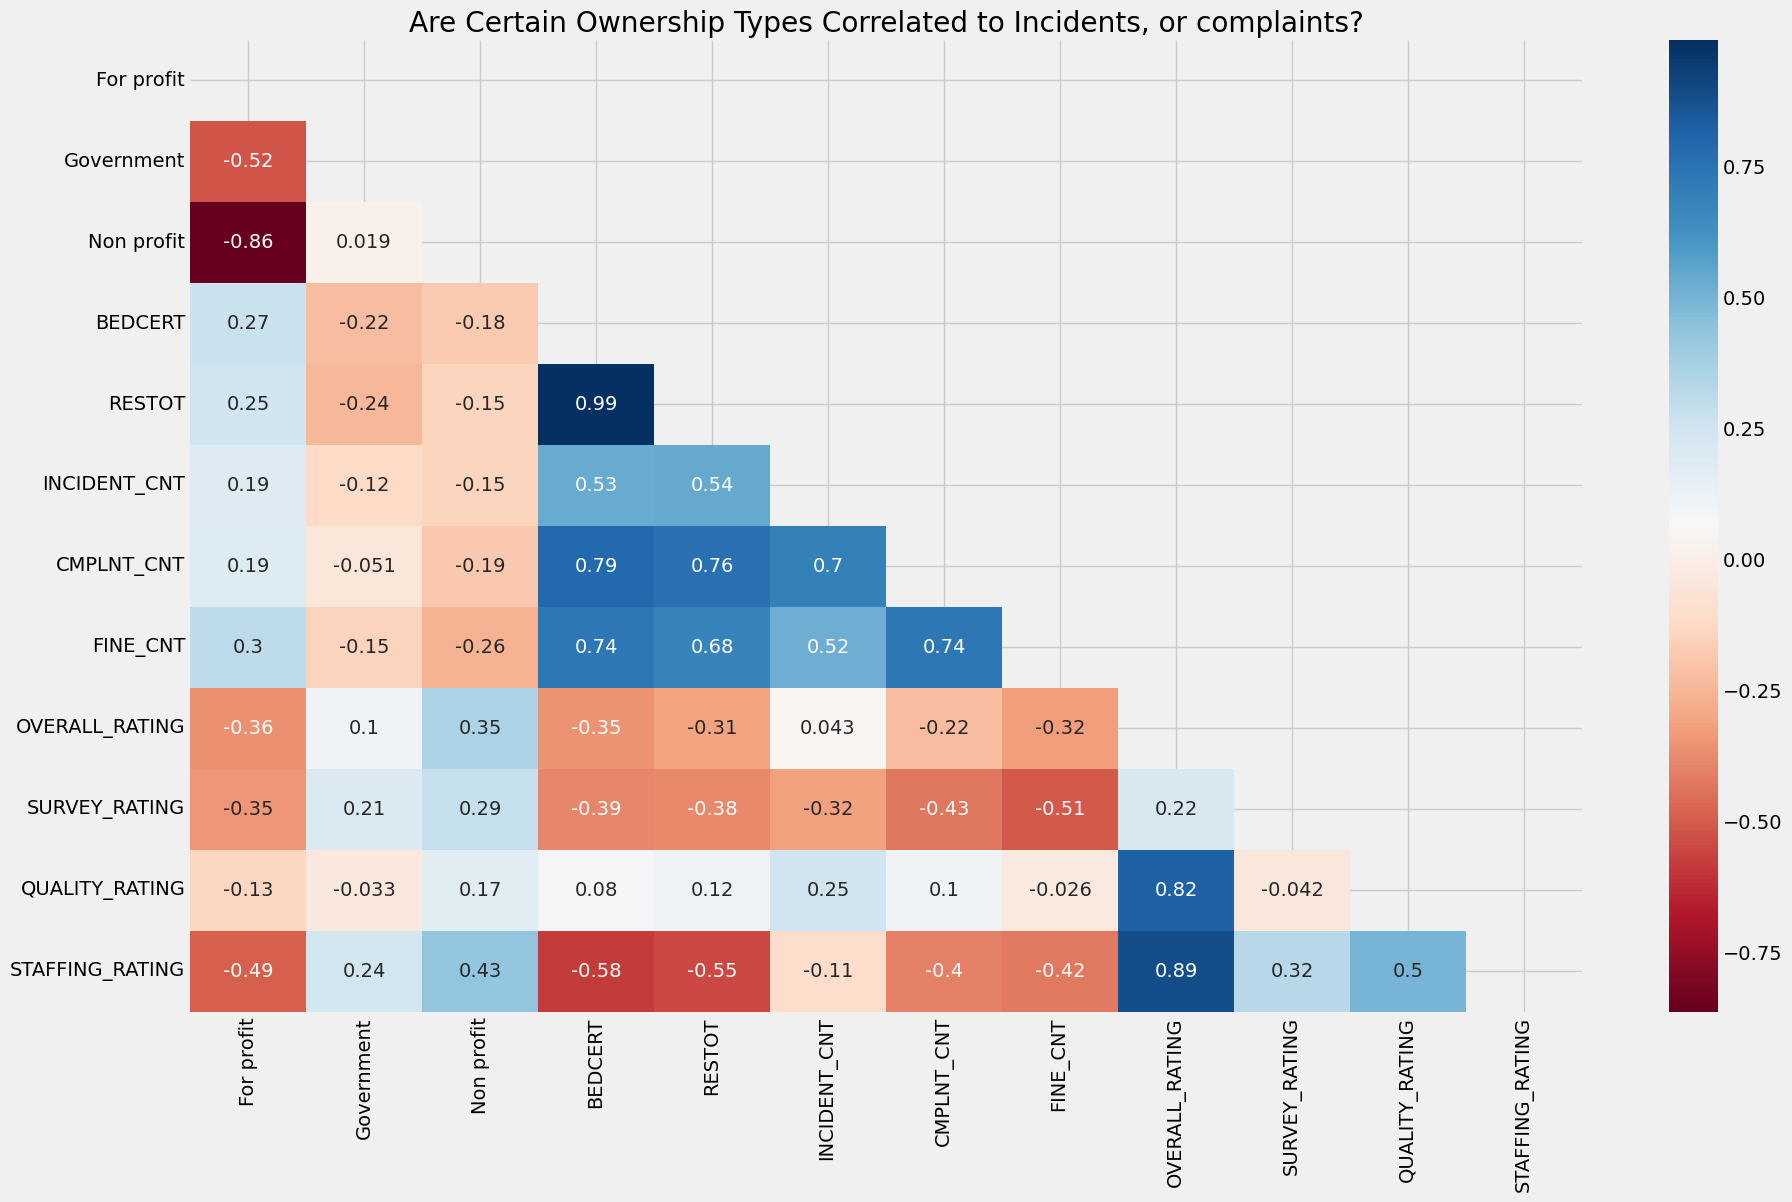

In [14]:
ownership_by_state = df.groupby('STATE')\
    ['ownership'].value_counts(normalize=True)\
    .unstack(level=1).round(2).reset_index()
    
ownership_by_state.columns = ownership_by_state.columns.str.strip()

ownership_by_state = ownership_by_state.sort_values(by='For profit',ascending=False).dropna()

states = ownership_by_state\
    .merge(total_pivs['STATE'],
           on='STATE',
           how='left').merge(rated_pivs['STATE'],
                             on='STATE',
                             how='left').set_index('STATE')

corr = states.corr(method='pearson')

mask = np.triu(np.ones_like(corr))


plt.figure(figsize=(20,12))
sns.heatmap(corr,mask=mask,
            cmap='RdBu',
            annot=True)

plt.title('Are Certain Ownership Types Correlated to Incidents, or complaints?')

In [15]:
comp_df.groupby('STATE')['ownership'].value_counts(normalize=True).unstack(level=0).round(2)

STATE          CA    MD    MI    TX    WA
ownership                                
For profit   0.84  0.72  0.71  0.81  0.73
Government   0.03  0.02  0.08  0.11  0.06
Non profit   0.13  0.26  0.21  0.08  0.21

In [16]:
df2 = pd.read_csv('/Users/jack/Desktop/Cleaned Data New/Prov/covid_providers.csv',parse_dates=['DATE FIRST APPROVED TO PROVIDE MEDICARE AND MEDICAID SERVICES'
                                                                                               ,'PROCESSING DATE'],index_col=['PROCESSING DATE']).infer_objects()

df2 = df2.assign(year = df2.index.year)

In [17]:
df = df.drop(['EXP_AIDE','EXP_LPN','EXP_RN','EXP_TOTAL'],axis=1).copy()

In [18]:
rate = df.groupby('ownership')[['OVERALL_RATING', 'SURVEY_RATING', 'QUALITY_RATING',
       'STAFFING_RATING','FINE_TOT']].mean().round(2)

inc_by_own = df.groupby('ownership')[['INCIDENT_CNT', 'CMPLNT_CNT',
       'FINE_CNT', 'PAYDEN_CNT', 'TOT_PENLTY_CNT']].sum()

#average ratings and count of fines by ownership type, join pivs and rename columns 
own_piv = rate\
    .merge(inc_by_own,left_index=True,right_index=True)\
    .rename(columns={'OVERALL_RATING':'avg_ovr_rating', 
                                                                                'SURVEY_RATING':'avg_survey_rating', 
                                                                                'QUALITY_RATING':'avg_quality_rating',
                                                                                'STAFFING_RATING':'avg_staff_rating',
       'FINE_TOT':'avg_total_fine', 
       'INCIDENT_CNT':'total_incident', 
       'CMPLNT_CNT':'total_complaint',
       'FINE_CNT':'total_fine', 
       'PAYDEN_CNT':'total_pay_denial',
       'TOT_PENLTY_CNT':'total_penalty'})
    

In [19]:
import plotly.graph_objects as go

melt_rate = ratings_by_state\
    .reset_index()\
        .melt(id_vars='STATE',
                      var_name='RATING',
                      value_name='values'
                      ,value_vars=['OVERALL_RATING',
                                   'SURVEY_RATING',
                                   'QUALITY_RATING',
                                   'STAFFING_RATING'])
        
top = px.bar(ratings_by_state\
    .mean(axis=1)[:10].round(2).sort_values(),
    color=ratings_by_state.index[:10],
    title='Top 10 Rated States (All Ratings)')

bottom  = px.bar(ratings_by_state\
    .mean(axis=1)[-10:].round(2).sort_values(),
    color=ratings_by_state.index[-10:],
    title='Bottom 10 Rated States (All Ratings)')


top.show()

bottom.show()

In [20]:
rate = df.groupby('CERTIFICATION')[['OVERALL_RATING', 'SURVEY_RATING', 'QUALITY_RATING',
       'STAFFING_RATING','FINE_TOT']].mean().round(2)

inc_by_own = df.groupby('CERTIFICATION')[['INCIDENT_CNT', 'CMPLNT_CNT',
       'FINE_CNT', 'PAYDEN_CNT', 'TOT_PENLTY_CNT']].sum()

#average ratings and count of fines by ownership type, join pivs and rename columns 
cert_piv = rate\
    .merge(inc_by_own,left_index=True,right_index=True)\
    .rename(columns={'OVERALL_RATING':'avg_ovr_rating', 
                                                                                'SURVEY_RATING':'avg_survey_rating', 
                                                                                'QUALITY_RATING':'avg_quality_rating',
                                                                                'STAFFING_RATING':'avg_staff_rating',
       'FINE_TOT':'avg_total_fine', 
       'INCIDENT_CNT':'total_incident', 
       'CMPLNT_CNT':'total_complaint',
       'FINE_CNT':'total_fine', 
       'PAYDEN_CNT':'total_pay_denial',
       'TOT_PENLTY_CNT':'total_penalty'})
    
cert_piv = cert_piv.T

cert_piv

CERTIFICATION       Medicaid  Medicare  Medicare and Medicaid
avg_ovr_rating          3.67      4.36                   3.17
avg_survey_rating       3.22      3.80                   2.76
avg_quality_rating      3.70      3.93                   3.64
avg_staff_rating        3.53      4.29                   3.06
avg_total_fine          0.00   3600.95               12798.50
total_incident       2759.00   1363.00               84745.00
total_complaint      3046.00   3893.00              300186.00
total_fine              0.00    586.00               30494.00
total_pay_denial        0.00    139.00                7483.00
total_penalty           0.00    725.00               37977.00

In [21]:
df2 = df2.reset_index(drop=True)\
    .set_index('FEDERAL PROVIDER NUMBER')

Text(0.5, 1.0, 'Do ADJ Total Hours Correlate to Rating?')

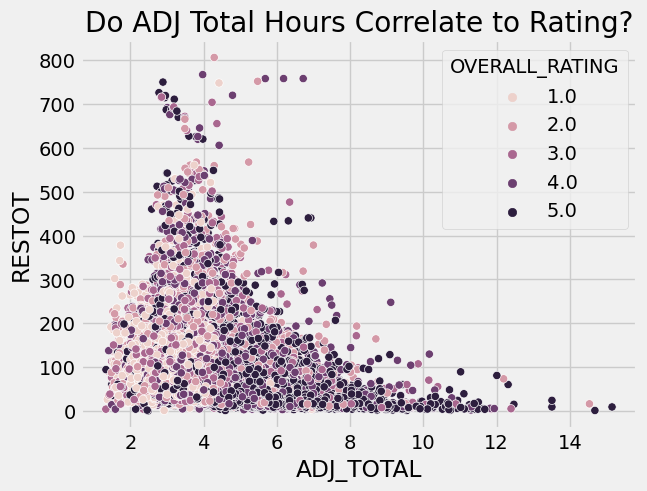

In [22]:
sns.scatterplot(data=df, 
                x='ADJ_TOTAL',
                y="RESTOT",
                hue='OVERALL_RATING')

plt.title('Do ADJ Total Hours Correlate to Rating?')

#it seems that mid-size facilities (in terms of people served per day are achieving lower ratings)

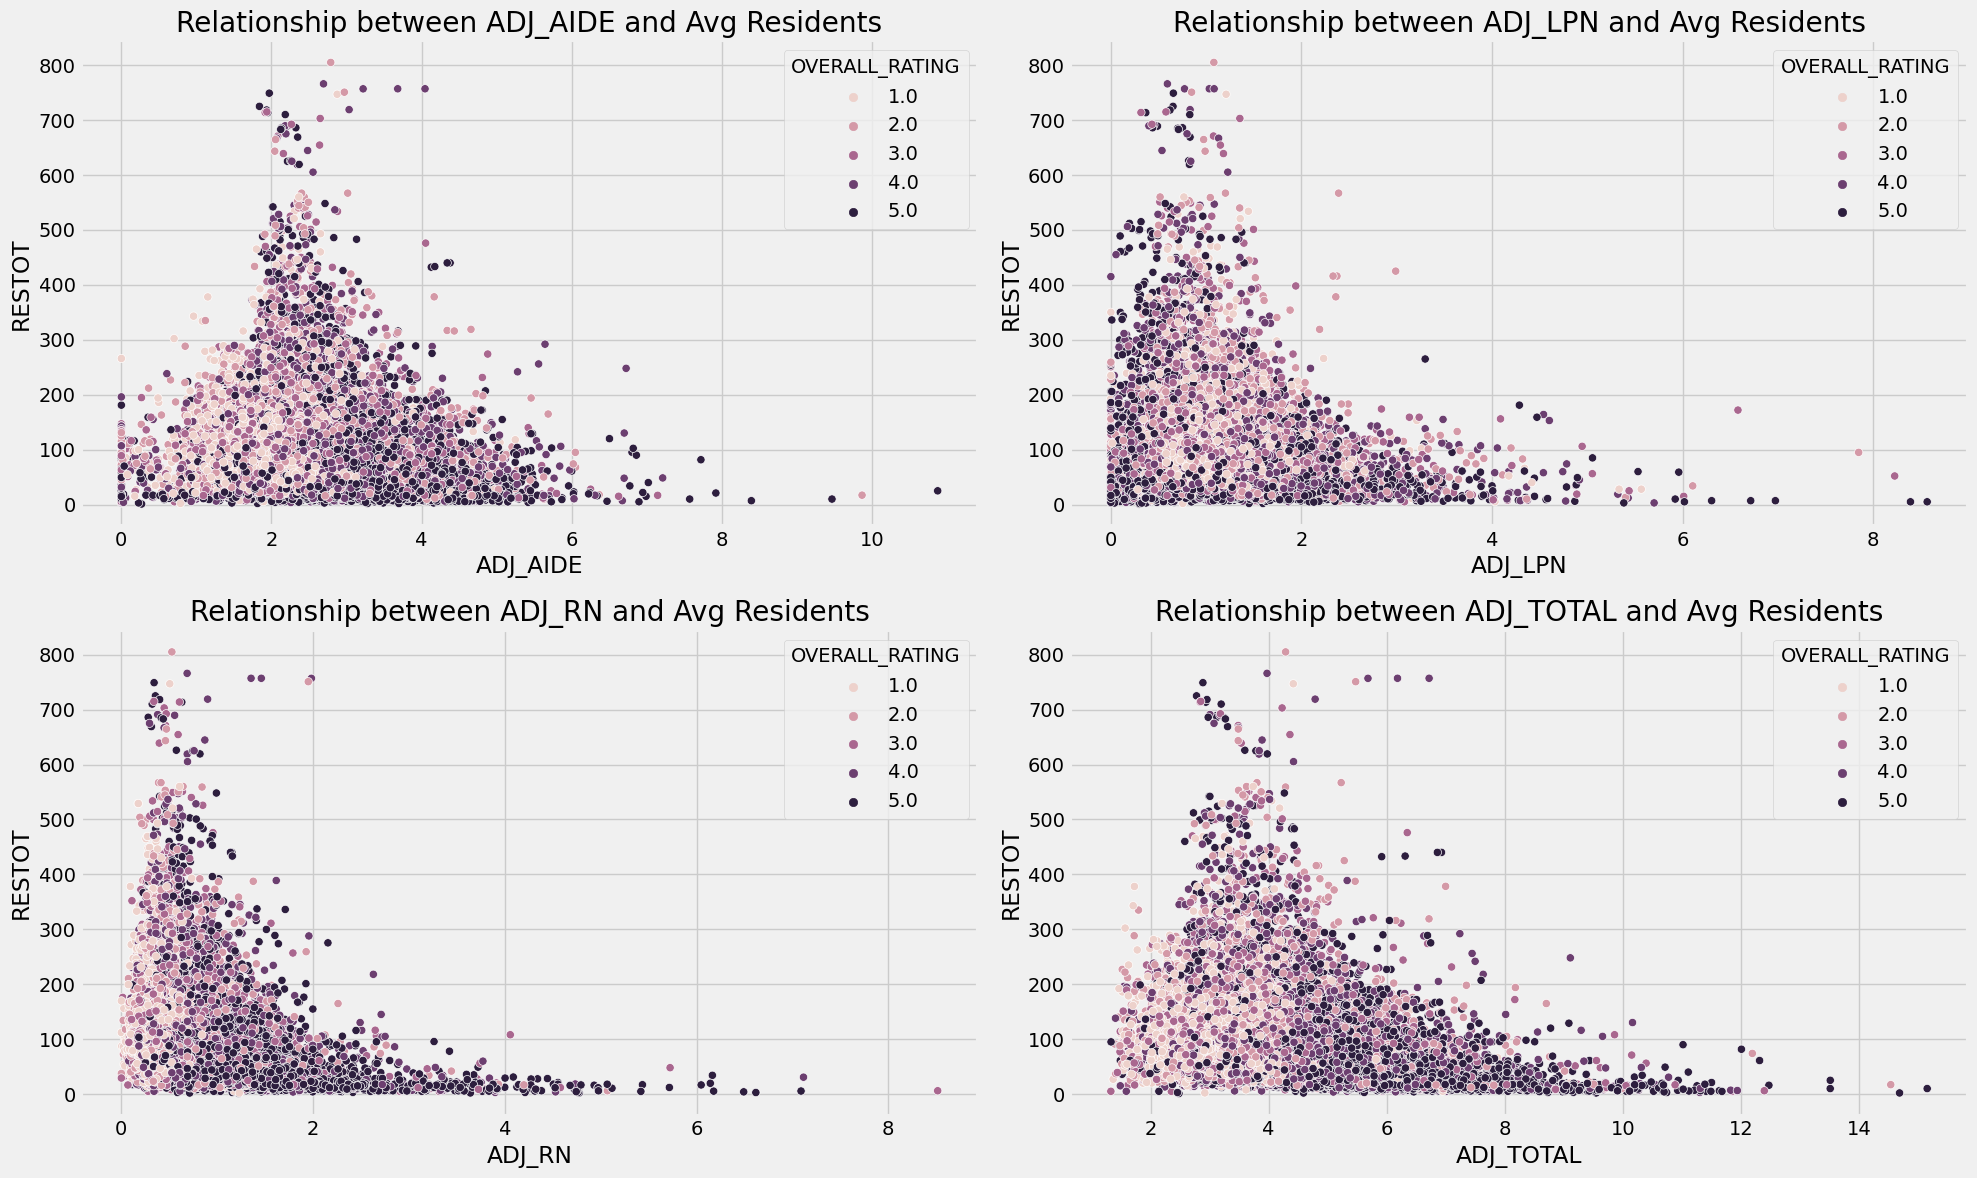

In [23]:
adj_hrs = df.filter(like='ADJ').columns

nrows = len(adj_hrs) // 2

fig, axes = plt.subplots(ncols=2,
                         nrows=nrows, 
                         figsize=(20,12))

axes = axes.flatten()

for i, col in enumerate(adj_hrs): 
    
    sns.scatterplot(df,x=col,y='RESTOT',hue='OVERALL_RATING',ax=axes[i])
    
    axes[i].set_title(f'Relationship between {col} and Avg Residents')
    
plt.tight_layout()

plt.show()

#could the lognormal distribution indicate subcontracting nursing talent? (Are they keeping nursing talent accounted for? )
    

In [24]:
df2['NUMBER OF CITATIONS FROM INFECTION CONTROL INSPECTIONS'] = df2['NUMBER OF CITATIONS FROM INFECTION CONTROL INSPECTIONS'].fillna(0)

df.groupby('INHOSP')\
    [['BEDCERT','ADJ_TOTAL','INCIDENT_CNT','CMPLNT_CNT','FINE_CNT']]\
    .agg(['sum','count']).stack()
    
print(f'Percent of Providers in Hospital (Pre-Covid): {df.INHOSP.mean().round(3) * 100}%')

Percent of Providers in Hospital (Pre-Covid): 5.1%


In [25]:
print(f"Percent of Providers in Hospital (Covid): {df2['PROVIDER RESIDES IN HOSPITAL'].mean().round(3) * 100}%")

Percent of Providers in Hospital (Covid): 3.9%


#dropping case mix and reported hours in favor of adjusted hours, for now! 

In [26]:
cm = df2.filter(like='CASE').columns

reported = df2.filter(like='REPORTED').columns

df2 = df2.drop(cm,axis=1).drop(reported,axis=1).copy()

Text(0.5, 1.0, 'Correlation of Covid Features')

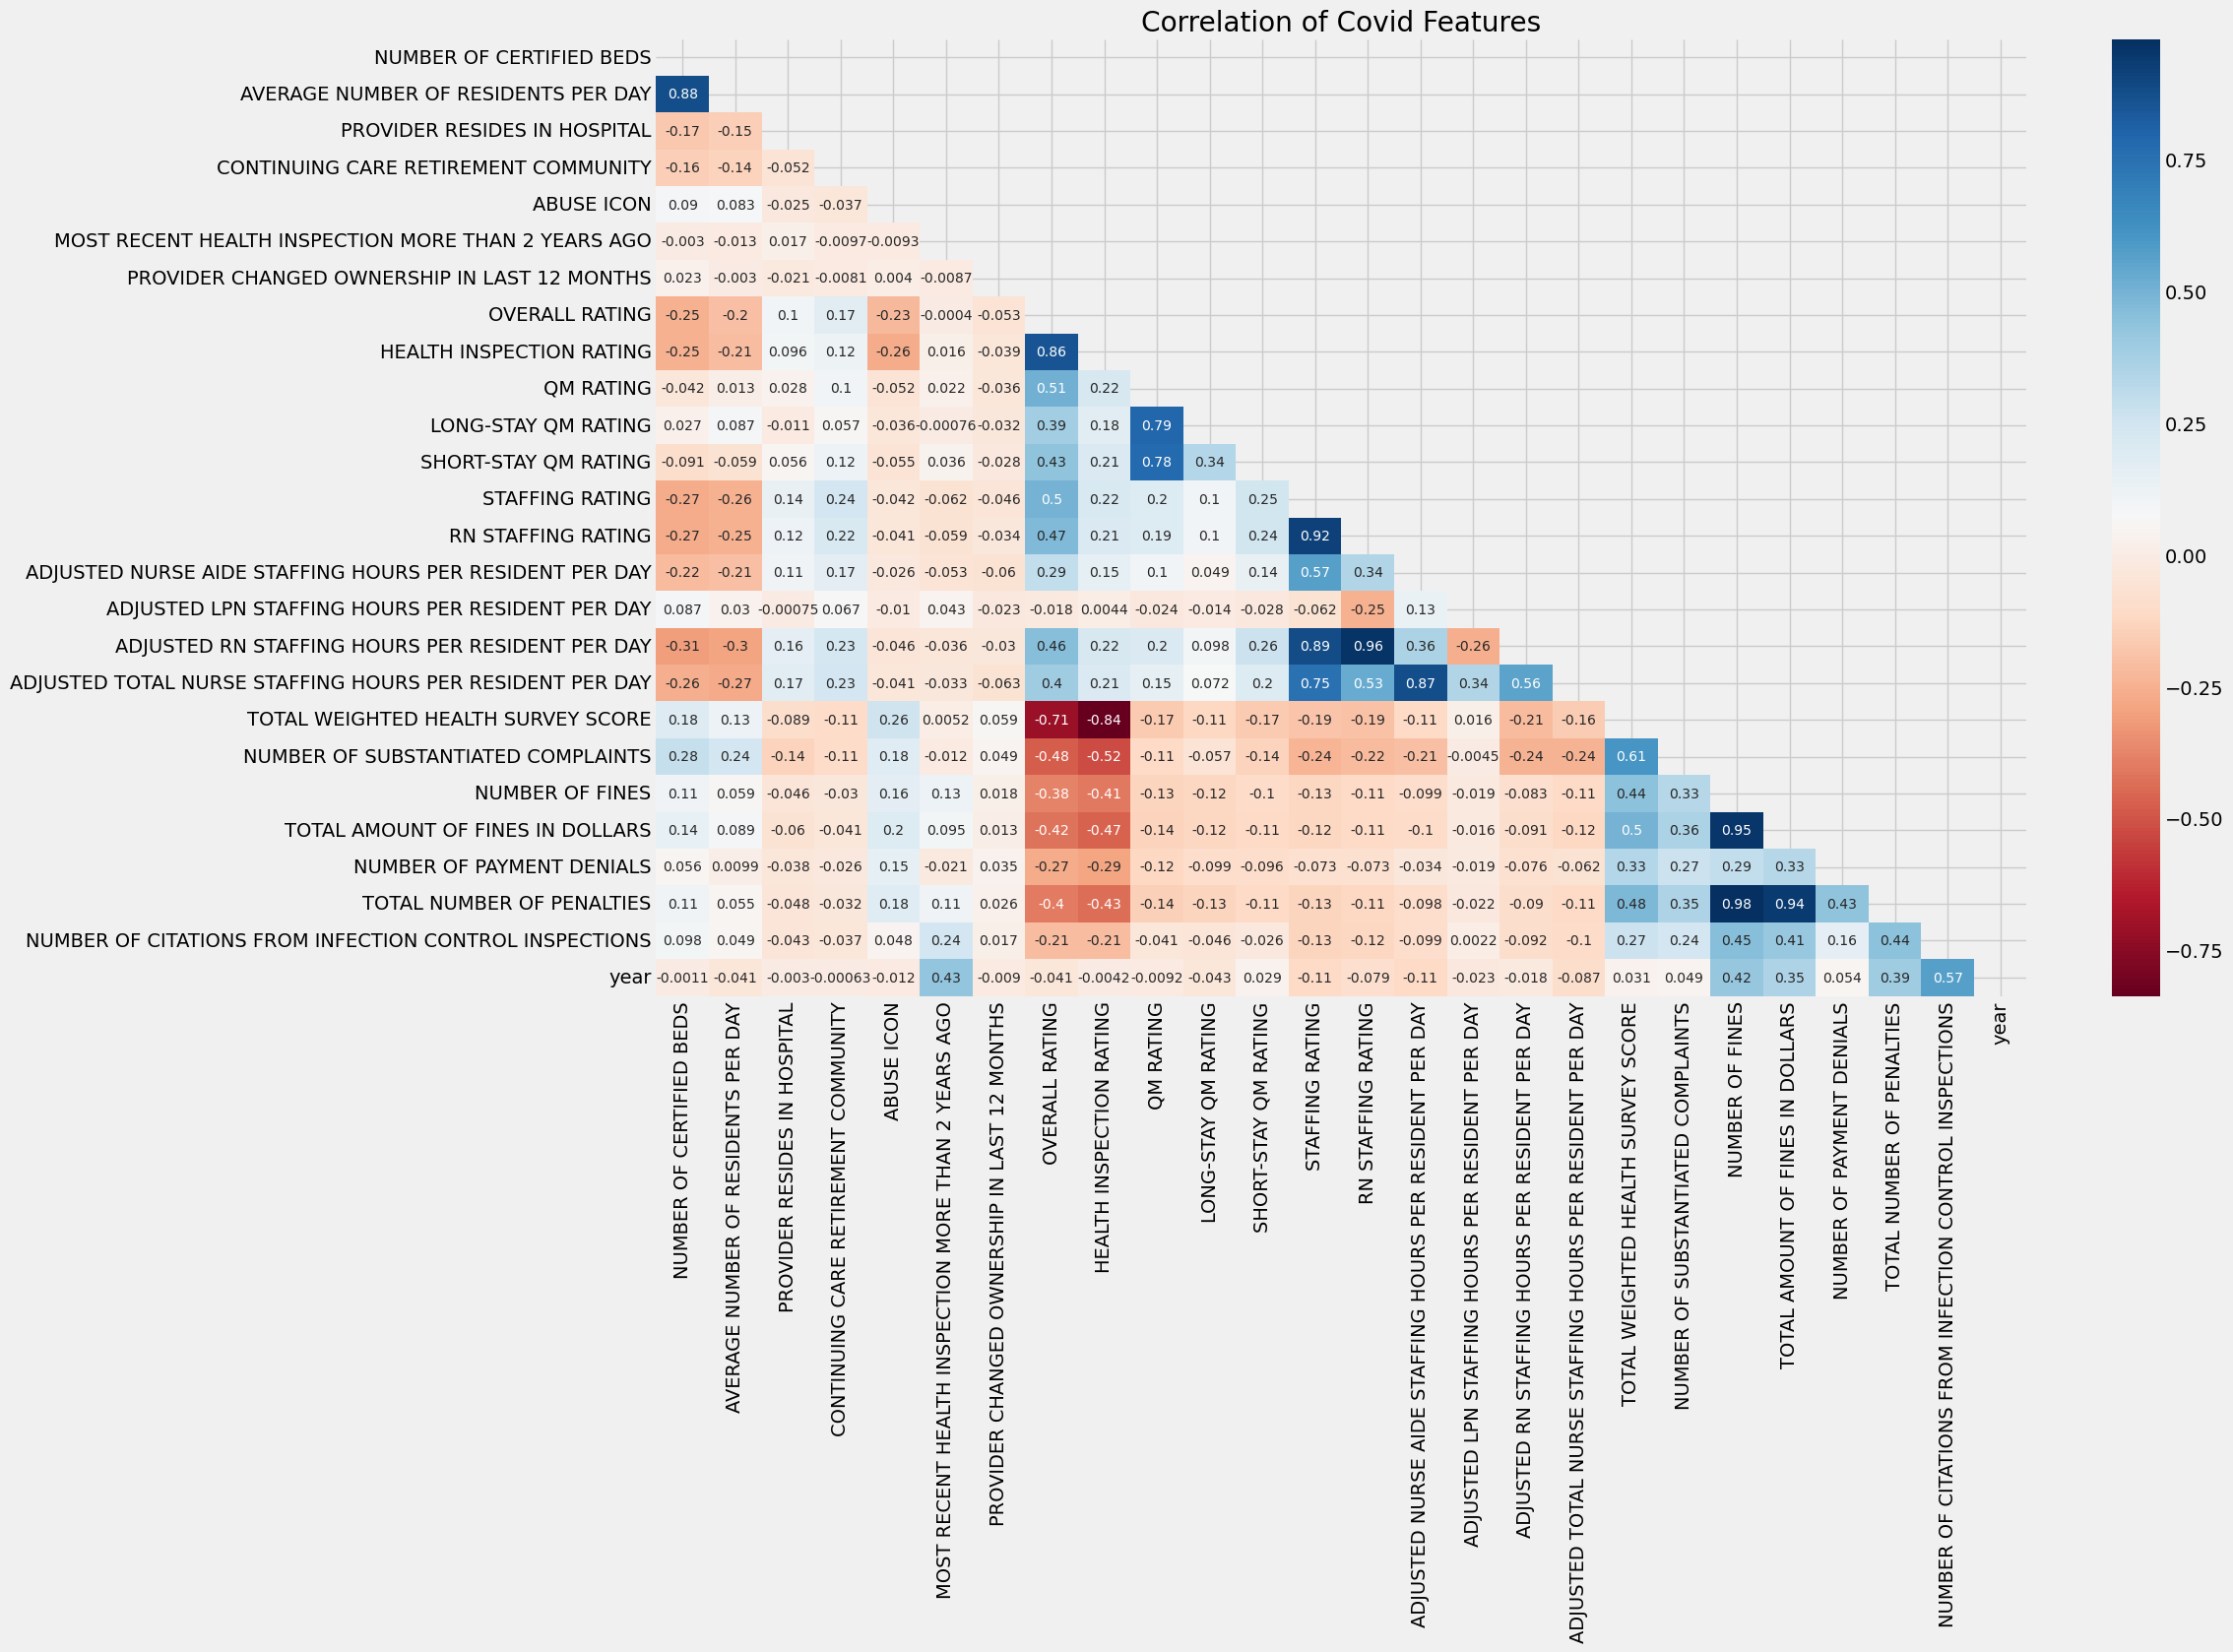

In [27]:
df2.sort_values(by='TOTAL AMOUNT OF FINES IN DOLLARS',ascending=False)


corr = df2.select_dtypes(include=[float,int]).corr(method='spearman')

mask = np.triu(np.ones_like(corr))

fig,ax = plt.subplots(figsize=(20,12))

sns.heatmap(corr,
            mask=mask,
            cmap='RdBu',
            annot=True,
            ax=ax,annot_kws={'fontsize':10})

ax.set_title('Correlation of Covid Features')

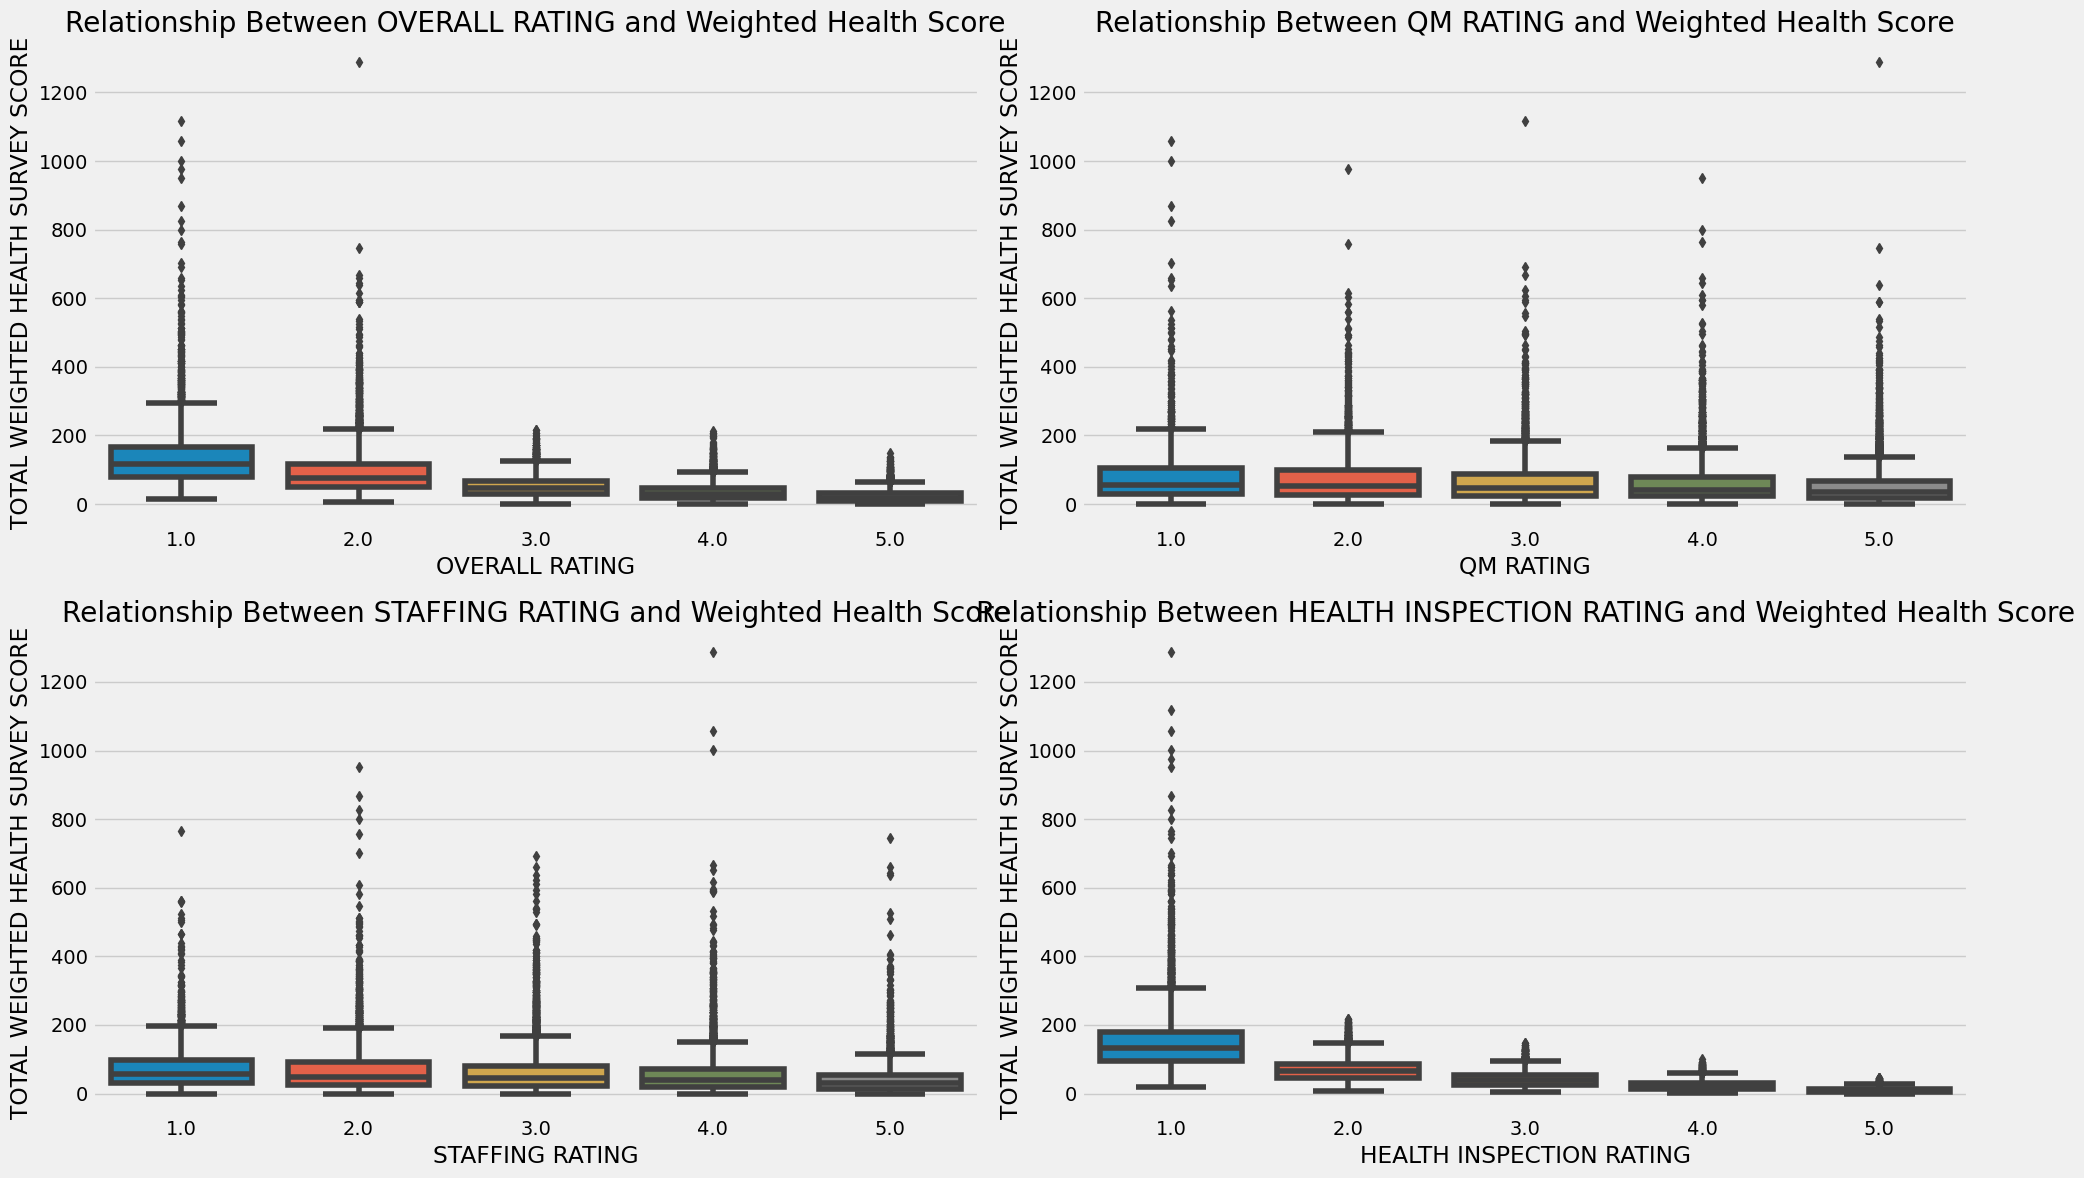

In [28]:
df2.columns

corr_cols = ['OVERALL RATING',
       'QM RATING','STAFFING RATING','HEALTH INSPECTION RATING']

fig, axes = plt.subplots(ncols=2,nrows=len(corr_cols)//2,figsize=(20,12))


axes = axes.flatten()

for j,i in enumerate(corr_cols): 
    
    sns.boxplot(data=df2,
                    x=i,
                    y='TOTAL WEIGHTED HEALTH SURVEY SCORE',ax=axes[j])
    
    axes[j].set_title(f'Relationship Between {i} and Weighted Health Score')
    
plt.tight_layout()

plt.show()

In [29]:

px.scatter(df2,x='NUMBER OF CERTIFIED BEDS',
           y='AVERAGE NUMBER OF RESIDENTS PER DAY',
           color='OVERALL RATING',
           title='Avg Daily Residents v Certified Beds (Covid)')

Investigate relationship between staffing hours and quality of service/total weighted health survey score


In [30]:
#splitting ownership to get a better view of ownership and operation type 

df2 = df2.assign(ownership = df2['OWNERSHIP TYPE'].str.split('-',expand=True)[0],
          op_type = df2['OWNERSHIP TYPE'].str.split('-',expand=True)[1]).drop('OWNERSHIP TYPE',axis=1)

In [31]:


ownership_piv = df2.groupby(['ownership'])\
    [['TOTAL WEIGHTED HEALTH SURVEY SCORE','ADJUSTED TOTAL NURSE STAFFING HOURS PER RESIDENT PER DAY']]\
        .mean().sort_values(by='TOTAL WEIGHTED HEALTH SURVEY SCORE',ascending=False).round(2)
        
        
        #for profit firms lead the way by a healthy margin in weighted health survey scores 
        
state_rate_cv = df2.groupby(['PROVIDER STATE','ownership'])\
    [['TOTAL WEIGHTED HEALTH SURVEY SCORE','ADJUSTED TOTAL NURSE STAFFING HOURS PER RESIDENT PER DAY']]\
        .agg(mean_health_score = ('TOTAL WEIGHTED HEALTH SURVEY SCORE',np.mean),
             avg_nursing_hours_per = ('ADJUSTED TOTAL NURSE STAFFING HOURS PER RESIDENT PER DAY',np.mean),
             occurences = ('TOTAL WEIGHTED HEALTH SURVEY SCORE','count'))\
                .sort_values(by='occurences',ascending=False).round(2)
                
                
#filter for states with atleast 50 facilities 
state_rate_cv = state_rate_cv[state_rate_cv.occurences >= 50]

display(state_rate_cv[:10])

display(ownership_piv)

mean_health_score  avg_nursing_hours_per  \
PROVIDER STATE ownership                                               
CA             For profit               94.20                   4.29   
TX             For profit               72.27                   3.38   
OH             For profit               67.46                   3.27   
IL             For profit               84.31                   3.02   
FL             For profit               51.88                   4.33   
NY             For profit               30.67                   3.19   
MO             For profit               69.00                   3.80   
PA             For profit               69.83                   3.30   
NC             For profit               48.51                   3.48   
PA             Non profit               37.73                   4.09   

                            occurences  
PROVIDER STATE ownership                
CA             For profit         1977  
TX             For profit         1896  
OH             For profit         1469  
IL             For profit         1060  
FL             For profit          958  
NY             For profit          798  
MO             For profit          787  
PA             For profit          707  
NC             For profit          692  
PA             Non profit          610

TOTAL WEIGHTED HEALTH SURVEY SCORE  \
ownership                                         
For profit                                69.79   
Government                                53.47   
Non profit                                44.65   

             ADJUSTED TOTAL NURSE STAFFING HOURS PER RESIDENT PER DAY  
ownership                                                              
For profit                                                3.75         
Government                                                4.57         
Non profit                                                4.53

In [32]:
#looking at ownership type as opposed to ownership entity.
# Are certain business structures handling the pandemic better? 

op_state_piv = df2.groupby(['PROVIDER STATE','op_type'])\
    [['TOTAL WEIGHTED HEALTH SURVEY SCORE','ADJUSTED TOTAL NURSE STAFFING HOURS PER RESIDENT PER DAY']]\
        .agg(mean_health_score = ('TOTAL WEIGHTED HEALTH SURVEY SCORE',np.mean),
             avg_nursing_hours_per = ('ADJUSTED TOTAL NURSE STAFFING HOURS PER RESIDENT PER DAY',np.mean),
             occurences = ('TOTAL WEIGHTED HEALTH SURVEY SCORE','count'))\
                .sort_values(by='occurences',ascending=False).round(2)
                
                
op_state_piv[:10]

mean_health_score  avg_nursing_hours_per  \
PROVIDER STATE op_type                                                  
OH              Corporation              63.79                   3.46   
CA              Corporation              87.02                   4.50   
TX              Corporation              67.91                   3.49   
PA              Corporation              54.77                   3.67   
FL              Corporation              48.36                   4.44   
IL              Corporation              69.05                   3.42   
NY              Corporation              26.58                   3.57   
IA              Corporation              34.27                   4.05   
IN              Corporation              61.56                   3.46   
MO              Corporation              61.48                   4.00   

                             occurences  
PROVIDER STATE op_type                   
OH              Corporation        1531  
CA              Corporation        1527  
TX              Corporation        1366  
PA              Corporation        1106  
FL              Corporation         970  
IL              Corporation         848  
NY              Corporation         766  
IA              Corporation         666  
IN              Corporation         664  
MO              Corporation         655

Look at Ratings by year in pre and post covid populations 

In [33]:
year_state_rate = df2.groupby(['year','PROVIDER STATE'])[['OVERALL RATING']]\
    .agg(['count','mean']).round(2)\
        .sort_values(by=('OVERALL RATING','count'),ascending=False)
        
year_state_covid = year_state_rate.loc[2020].merge(year_state_rate.loc[2021],
                                     left_index=True,
                                     right_index=True)\
                                         .rename(columns={'OVERALL RATING_x':'Rating_2020',
                                                                       'OVERALL RATING_y':'Rating_2021'})

In [34]:
df = df.assign(year = df.index.year)


pre_cov_rating = df.groupby(['year','STATE'])[['OVERALL_RATING']]\
    .agg(['count','mean']).round(2).sort_values(by=('OVERALL_RATING','count'),ascending=False)\
        .unstack(level=0)[('OVERALL_RATING','mean')]
        
        
year_state_cov_avg = year_state_covid.stack(level=0)['mean'].unstack()


ratings_over_time = pre_cov_rating\
    .merge(year_state_cov_avg,
           how='left',
           left_index=True,right_index=True)

In [35]:
ratings_over_time.columns = ['Rating_2015', 
                             'Rating_2016', 
                             'Rating_2017',
                             'Rating_2018', 'Rating_2019', 
                             'Rating_2020', 'Rating_2021']
    
#melt ratings over time 
melted_ratings = pd.wide_to_long(ratings_over_time.reset_index(), 
                                 stubnames='Rating_', 
                                 i='STATE', 
                                 j='Year') \
                   .reset_index() \
                   .rename(columns={'Rating_': 'Rating'})
                   
                   
                   
                   
melted_ratings = melted_ratings.set_index('Year')

px.box(melted_ratings,
       x=melted_ratings.index,
       y='Rating',
       hover_data=['STATE'],
       title='Ratings Over Time Pre/Post Covid')

<Axes: title={'center': 'Penalties Pre and Post Covid'}>

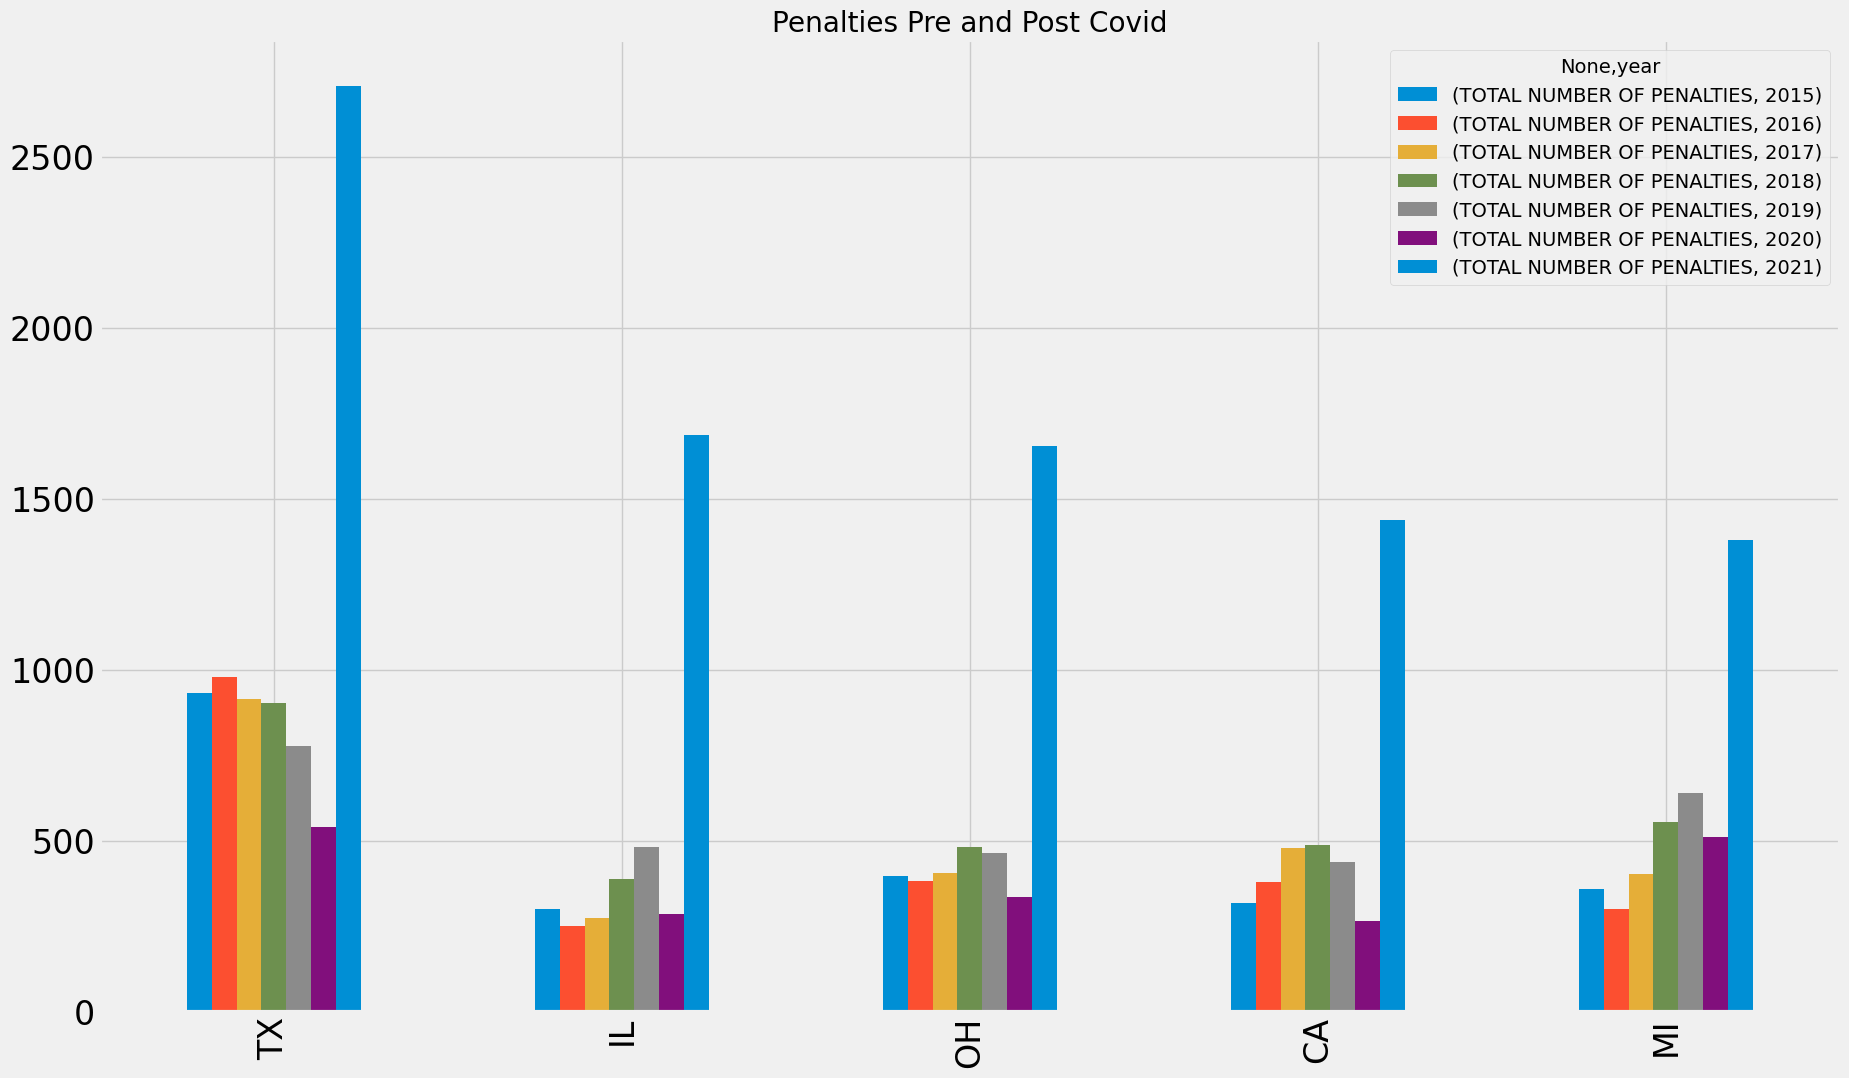

In [36]:
covid_penalties = df2.groupby(['PROVIDER STATE','year'])\
    [['TOTAL NUMBER OF PENALTIES']].sum()\
        .sort_values(by='TOTAL NUMBER OF PENALTIES',ascending=False)\
            .unstack(level=1)
            
            
#.plot(kind='bar',title='Penalties by State-Year (Covid) Top 15')
            
            
pens_over_time = df.groupby(['STATE','year'])\
    [['TOT_PENLTY_CNT']].sum().unstack()\
        .rename(columns={'TOT_PENLTY_CNT':'TOTAL NUMBER OF PENALTIES'})\
            .merge(covid_penalties,left_index=True,right_index=True)
            
pen_piv = pens_over_time.stack().unstack()\
    .sort_values(by=('TOTAL NUMBER OF PENALTIES',2021),ascending=False)[:5]
    
    
pen_piv.plot(kind='bar',
                                                                                  figsize=(20,12),
                                                                                  title='Penalties Pre and Post Covid',
                                                                                  fontsize=24)
    
    

In [37]:
qc = pd.read_csv('/Users/jack/Desktop/Cleaned Data New/cleaned_mast_qc.csv').infer_objects()

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_75234/12174218.py:1: DtypeWarning:

Columns (11,13,15,17,19) have mixed types. Specify dtype option on import or set low_memory=False.



In [38]:
qc = qc.drop(['ADDRESS','Unnamed: 0'],axis=1).set_index(pd.to_datetime(qc.FILEDATE))

In [39]:
#these columns describe why the data is missing

missing_exp = qc.filter(like='FN')

footnotes = qc.filter(like='FN').columns

qc = qc.drop(footnotes,axis=1)

In [40]:
zips = pd.read_csv('/Users/jack/Desktop/ManhattanProject/simplemaps_uszips_basicv1.84/uszips.csv').infer_objects()

#pull in demographic data
qc = qc.merge(zips[['lat','lng','zip','population']],
         left_on='ZIP',
         right_on='zip',
         how='left')\
             .drop(['zip'],axis=1).set_index(pd.to_datetime(qc['FILEDATE']))\
             .rename(columns={'population':'county_pop_2020'})
             
 #drop file date column as we no longer need             
qc = qc.drop('FILEDATE',axis=1)

In [41]:
#investigate why an overall rating of 1 is still fetching high staff ratings 

low_rated_hi_score = df2[(df2['OVERALL RATING'] == 1) |(df2['OVERALL RATING'] == 2)][['TOTAL WEIGHTED HEALTH SURVEY SCORE']]\
    .sort_values(by='TOTAL WEIGHTED HEALTH SURVEY SCORE',ascending=False)
    
#pulling those providers out of index, 1000 providers had a rating of 1 or 2 but a very high health survey score for atleast 1 of the two years
#this is because a higher score is a result of more penalties

providers_low_rate_hi_score = low_rated_hi_score[low_rated_hi_score['TOTAL WEIGHTED HEALTH SURVEY SCORE'] > low_rated_hi_score['TOTAL WEIGHTED HEALTH SURVEY SCORE'].quantile(.9)].index

low = df2.loc[providers_low_rate_hi_score]

low_qc = qc[qc.PROVNUM.isin(providers_low_rate_hi_score)]

In [42]:
new_df1 = df.reset_index()[['PROVNUM', 'STATE', 'BEDCERT', 'RESTOT', 'CERTIFICATION',
       'INHOSP', 'PARTICIPATION_DATE', 'CCRC_FACIL', 'CHOW_LAST_12MOS',
       'RESFAMCOUNCIL', 'OVERALL_RATING', 'SURVEY_RATING',
       'STAFFING_RATING', 'RN_STAFFING_RATING',  'ADJ_AIDE', 'ADJ_LPN', 'ADJ_RN',
       'ADJ_TOTAL', 'WEIGHTED_ALL_CYCLES_SCORE',  'CMPLNT_CNT',
       'FINE_CNT', 'FINE_TOT', 'PAYDEN_CNT', 'TOT_PENLTY_CNT', 'ownership',
       'op_type', 'year']]


#cols remaining in df1 that may not be in df2 
['INCIDENT_CNT''AIDHRD', 'VOCHRD', 'RNHRD',
       'TOTLICHRD', 'TOTHRD', 'PTHRD','QUALITY_RATING',]

new_df2 = df2.reset_index()[['FEDERAL PROVIDER NUMBER', 'PROVIDER STATE', 'NUMBER OF CERTIFIED BEDS',
       'AVERAGE NUMBER OF RESIDENTS PER DAY', 'PROVIDER TYPE',
       'PROVIDER RESIDES IN HOSPITAL',
       'DATE FIRST APPROVED TO PROVIDE MEDICARE AND MEDICAID SERVICES',
       'CONTINUING CARE RETIREMENT COMMUNITY',
       'PROVIDER CHANGED OWNERSHIP IN LAST 12 MONTHS',
       'WITH A RESIDENT AND FAMILY COUNCIL', 'OVERALL RATING',
       'HEALTH INSPECTION RATING',  'STAFFING RATING', 'RN STAFFING RATING',
       'ADJUSTED NURSE AIDE STAFFING HOURS PER RESIDENT PER DAY',
       'ADJUSTED LPN STAFFING HOURS PER RESIDENT PER DAY',
       'ADJUSTED RN STAFFING HOURS PER RESIDENT PER DAY',
       'ADJUSTED TOTAL NURSE STAFFING HOURS PER RESIDENT PER DAY',
       'TOTAL WEIGHTED HEALTH SURVEY SCORE',
       'NUMBER OF SUBSTANTIATED COMPLAINTS', 'NUMBER OF FINES',
       'TOTAL AMOUNT OF FINES IN DOLLARS', 'NUMBER OF PAYMENT DENIALS',
       'TOTAL NUMBER OF PENALTIES',
       'ownership', 'op_type','year']]

#cols remaining in df2 that may not be in df1 
#['QM RATING', 'LONG-STAY QM RATING',
    #   'SHORT-STAY QM RATING', 'NUMBER OF CITATIONS FROM INFECTION CONTROL INSPECTIONS']

In [43]:
#create master providers table out of 27 columns found above

prov = pd.DataFrame(columns=new_df2.columns,data=np.concatenate([new_df1,new_df2])).infer_objects()


#fixing column names 
prov.columns = prov.columns.str.replace(' ','_').str.lower()

In [44]:
prov['total_weighted_health_survey_score'] = prov['total_weighted_health_survey_score']\
    .str.split('.',expand=True)[0]

In [45]:
key_state = prov.provider_state.value_counts() > 500

key_states = key_state[key_state == True].index

#drop non-key states, in this case a state must have atleast 500 records 
new_prov = prov[prov.provider_state.isin(key_states)]


yr_state = new_prov\
    .groupby(['year','provider_state'])\
        [['number_of_certified_beds',
                                             'average_number_of_residents_per_day',
                                             'number_of_substantiated_complaints',
                                             'number_of_fines',
                                             'total_number_of_penalties']].agg(avg_cert_beds = ('number_of_certified_beds','mean'),
                                                                               avg_residents = ('average_number_of_residents_per_day','mean'),
                                                                               num_complaints = ('number_of_substantiated_complaints','sum'),
                                                                               num_fines = ('number_of_fines','sum'),
                                                                               num_penalties = ('total_number_of_penalties','sum')).round()

In [46]:
yr_state_piv = yr_state.unstack(level=0).stack(level=0)

#top 10 states with largest total covid response
states = yr_state_piv.reset_index(level=0).sort_values(by=[2021],ascending=[False]).provider_state.unique()[:15]

for state in states: 
    
    state_data = yr_state_piv.loc[state].swapaxes(0,1)
    
    fig = px.bar(state_data,
                 title=f"{state}'s Covid Response",
                 barmode='group')
    
    fig.show()

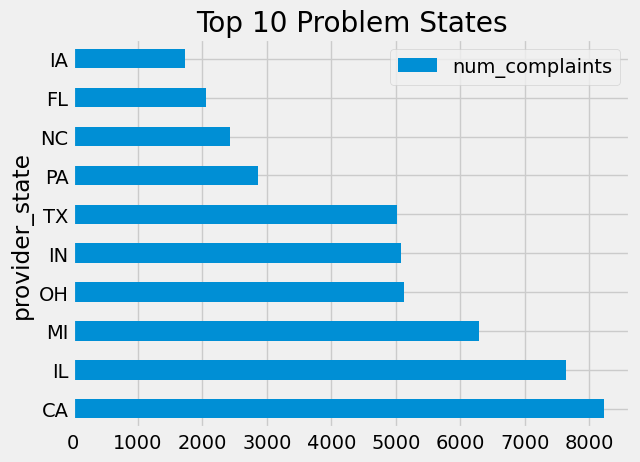

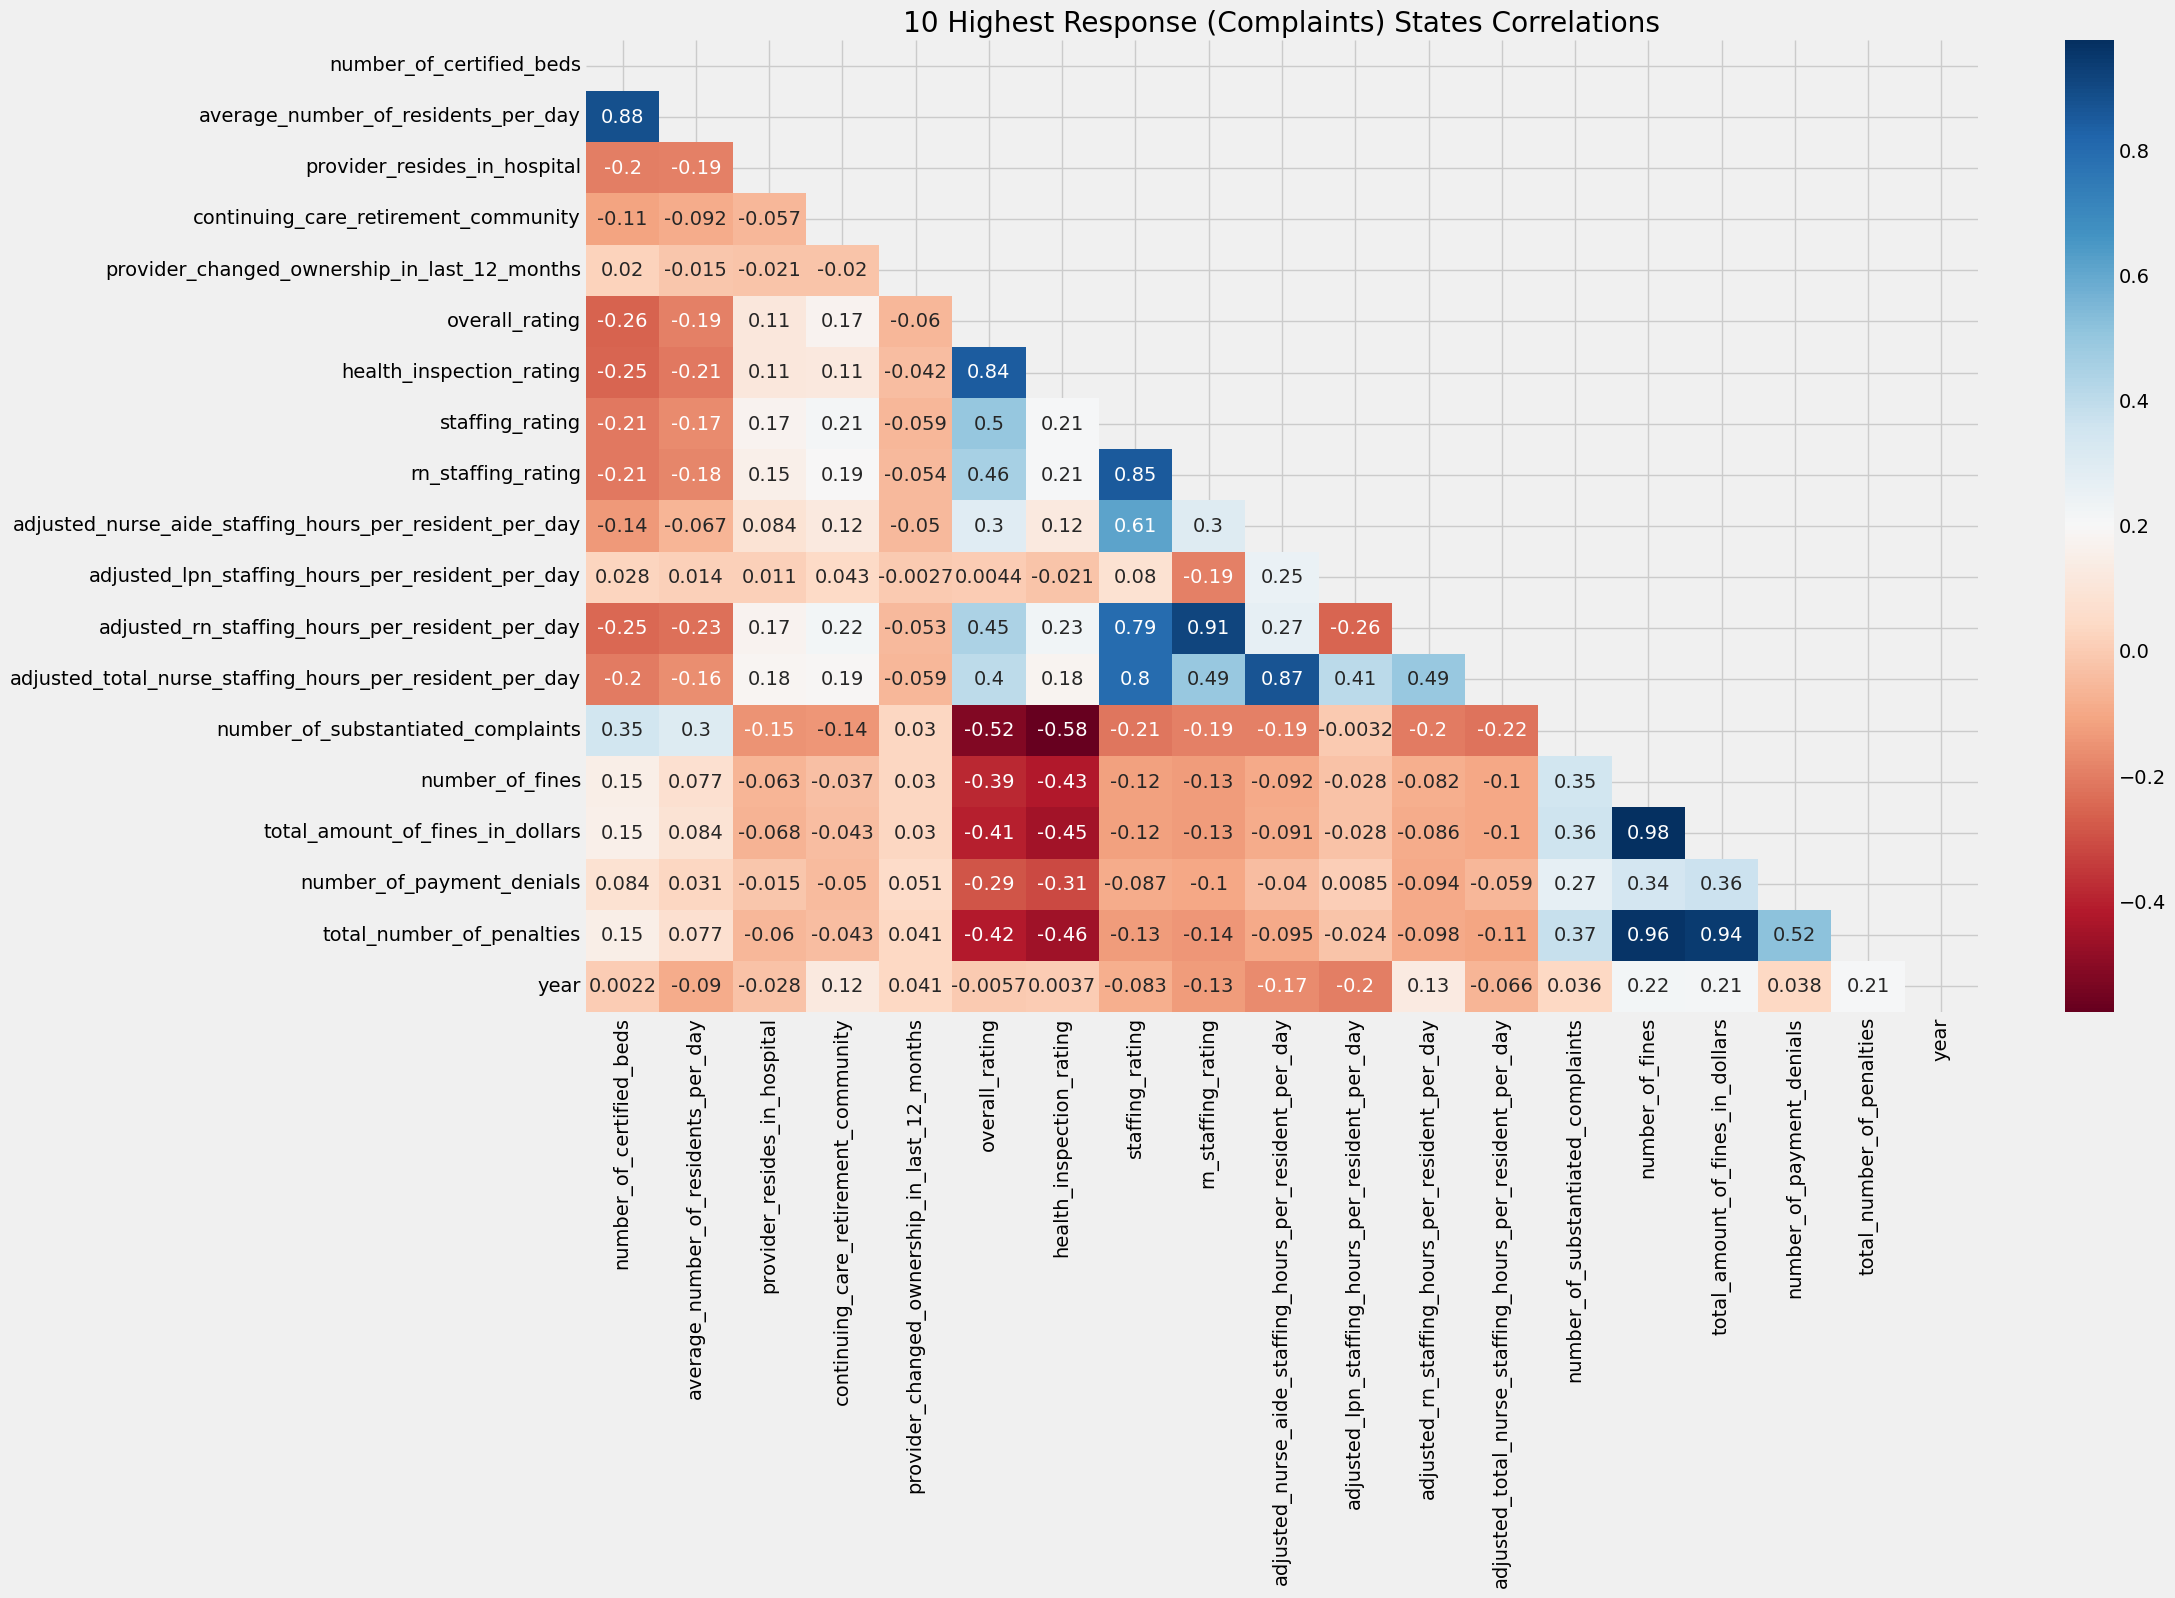

In [47]:
bad_resp = yr_state.loc[('2021',)][['num_complaints']]\
    .sort_values(by='num_complaints',ascending=False)
    
bad_resp[:10].plot(kind='barh',title='Top 10 Problem States')


worst_states = bad_resp[:10].index


#look at worst states in isolation 

df1 = new_prov[new_prov.provider_state.isin(worst_states)]


corr = df1.select_dtypes(include=[int,float]).corr(method='spearman')



mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(20,12))

sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu')

plt.title('10 Highest Response (Complaints) States Correlations')

plt.show()

In [48]:
# Assuming filtered_corr_df is your filtered correlation DataFrame
# and threshold is the minimum correlation strength you want to consider
threshold = 0.75  # Update with your desired threshold

# Filter out correlations of columns with themselves and slice for correlations of a certain strength
filtered_corr_df = corr[(corr < 1.0) & (corr.abs() >= threshold)]

# Reset index to convert the DataFrame into long format
filtered_corr_df = filtered_corr_df.stack().reset_index()

# Rename columns for clarity
filtered_corr_df.columns = ['Column 1', 'Column 2', 'Correlation']


In [49]:
corr_table = filtered_corr_df.round(2)

#is the strong correlation in rn hours and staffing rating signifying a staffing shortage in these states? 
corr_table

#create summary of hours as they relate to rating for 10 worst states (highest complaints)

worst = df1[['adjusted_nurse_aide_staffing_hours_per_resident_per_day',
       'adjusted_lpn_staffing_hours_per_resident_per_day',
       'adjusted_rn_staffing_hours_per_resident_per_day',
       'adjusted_total_nurse_staffing_hours_per_resident_per_day','overall_rating',
        'number_of_substantiated_complaints', 'number_of_fines',
       'total_amount_of_fines_in_dollars', 'number_of_payment_denials',
       'total_number_of_penalties']].agg(['mean','std','count'])

#top 10 states with least complaints 
best_states = bad_resp[-10:].index

df2 = new_prov[new_prov.provider_state.isin(best_states)]

#create summary of hours as they relate to rating for 10 best states (lowest complaints)
best = df2[['adjusted_nurse_aide_staffing_hours_per_resident_per_day',
       'adjusted_lpn_staffing_hours_per_resident_per_day',
       'adjusted_rn_staffing_hours_per_resident_per_day',
       'adjusted_total_nurse_staffing_hours_per_resident_per_day','overall_rating', 'number_of_substantiated_complaints', 'number_of_fines',
       'total_amount_of_fines_in_dollars', 'number_of_payment_denials',
       'total_number_of_penalties',]].agg(['mean','std','count'])

Are the differences in best and worst states statistically significant? (Yes) (Two Sample T Test)

In [50]:
from scipy.stats import ttest_ind_from_stats

#run ttest on all columns in table to see difference in samples 

cols = ['adjusted_nurse_aide_staffing_hours_per_resident_per_day',
       'adjusted_lpn_staffing_hours_per_resident_per_day',
       'adjusted_rn_staffing_hours_per_resident_per_day',
       'adjusted_total_nurse_staffing_hours_per_resident_per_day','overall_rating',
        'number_of_substantiated_complaints', 'number_of_fines',
       'total_amount_of_fines_in_dollars', 'number_of_payment_denials',
       'total_number_of_penalties']

results = {}

for col in cols:
    
    #get sample means as mu 
    mu1 = best[col].loc['mean']
    
    mu2 = worst[col].loc['mean'] 
    #get standard devs as sigma 
    sig1 = best[col].loc['std']
    
    sig2 = worst[col].loc['std'] 
    #get sample sizes 
    n1 = best[col].loc['count']
    
    n2 = worst[col].loc['count']
    
    t_stat, p_val = ttest_ind_from_stats(mu1,sig1,n1,mu2,sig2,n2)
    
    #define alpha and test 
    
    alpha = .05 
    
    #test p_val 
    if p_val < alpha: 
        
        print(f'For {col} Populations are different reject H0')
        
    else: 
        print(f'For {col} Fail to Reject h0')

For adjusted_nurse_aide_staffing_hours_per_resident_per_day Populations are different reject H0
For adjusted_lpn_staffing_hours_per_resident_per_day Populations are different reject H0
For adjusted_rn_staffing_hours_per_resident_per_day Populations are different reject H0
For adjusted_total_nurse_staffing_hours_per_resident_per_day Populations are different reject H0
For overall_rating Populations are different reject H0
For number_of_substantiated_complaints Populations are different reject H0
For number_of_fines Populations are different reject H0
For total_amount_of_fines_in_dollars Populations are different reject H0
For number_of_payment_denials Populations are different reject H0
For total_number_of_penalties Populations are different reject H0


Look at providers and cost report to select features to predict operating margin. 

In [51]:
cost = pd.read_csv('/Users/jack/Desktop/ManhattanProject/cost_combined.csv').infer_objects()

#convert to datetime and extract year
cost['fiscal_year'] = pd.to_datetime(cost['fiscal_year_end_date']).dt.year

#cost['zip_code'].astype(int)

cost.provider_ccn = cost.provider_ccn.astype(str)

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_75234/1149121685.py:1: DtypeWarning:

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.



In [52]:

df = new_prov\
      .merge(cost[['provider_ccn','zip_code',
                     'rural_versus_urban','operating_margin','fiscal_year']],
               how='inner',
               left_on =['federal_provider_number','year'],
               right_on=['provider_ccn','fiscal_year'])\
                 #   .merge(qc[['lat','lng','PROVNUM']],
                     #                                         left_on='federal_provider_number',
                                 #                             right_on='PROVNUM',how='inner')
#convert hyphenated zip back to more general zips 

df.zip_code = df.zip_code.str.split('-',expand=True)[0].astype(int)


ml = df.merge(zips[['zip','lat','lng','county_fips']],
         left_on='zip_code',right_on='zip')

READING IN ECONOMIC DATA 

In [53]:
import os 

#going to read in all files at once 

all_dfs = []

for i in range(7): 
    
    df = pd.read_excel('/Users/jack/Desktop/ManhattanProject/Unemployment Economic/laucnty15.xlsx',sheet_name=i) 
    
    all_dfs.append(df)
    
    mast_unemp = pd.concat(all_dfs)

Population/Demographics Data

In [54]:
#read in data
pop = pd.read_csv('/Users/jack/Desktop/ManhattanProject/county_complete.csv').infer_objects()

#cleaning columns to ensure I capture all years. 
pop.columns = pop.columns.str.replace('_','')

#transform wide-to-long 
pop_data = pd.wide_to_long(pop,
                           stubnames='pop',
                           i='fips',
                           j='year')[['state','name','pop']]\
                               .reset_index()
                               
#pull in 2018 population data 
pop_2018 = pd.read_csv(r'/Users/jack/Desktop/ManhattanProject/co-est2019-alldata.csv',
            encoding='ISO-8859-1').infer_objects()


pop_new = pd.wide_to_long(pop_2018.reset_index(),
                           stubnames='POPESTIMATE',
                           i=['index','STNAME','CTYNAME'],
                           j='year')[['POPESTIMATE']].reset_index()\
                               .drop('index',axis=1)
                               
cty_mask = np.where(pop_new.STNAME != pop_new.CTYNAME)


pop_est_2018 = pop_new.loc[cty_mask].query('year == 2018')

Adding fips code to 2018, this is not the best method but this SHOULD work

In [55]:
pop_est_2018 = pd.concat([pop_data.query('year == 2019')[['fips']].reset_index(drop=True),
           pop_est_2018.reset_index(drop=True)],axis=1)

In [56]:
pop_df = pd.DataFrame(np.concatenate([pop_data,
                             pop_est_2018[['fips','year','STNAME',
                                           'CTYNAME','POPESTIMATE']]]))

pop_df.columns = pop_data.columns


pop_df = pop_df.query('year > 2014').sort_values(by='year')\
    .reset_index(drop=True)
    
    
pop_covid = pd.read_excel('/Users/jack/Desktop/ManhattanProject/PopulationEstimates.xlsx')\
    .drop(0)
    
pop_covid = pd.wide_to_long(pop_covid.reset_index(),
                           stubnames='POP_ESTIMATE',
                           i=['FIPStxt','State','Area_Name'],
                           j='year',
                           sep='_')[['POP_ESTIMATE']].reset_index()\
                               .query('State != "PR"')

In [57]:
pop_mast = pd.DataFrame(np.concatenate([pop_df,
                             pop_covid[['FIPStxt','year','State',
                                               'Area_Name','POP_ESTIMATE']]]))


pop_mast.columns = pop_df.columns

pop_mast = pop_mast.sort_values(by='year').reset_index(drop=True)

In [201]:
#merge in unemp data on year and fips county code,
# extract year from facilitiy founded date as feature

ml_new = ml.merge(mast_unemp,
         how='inner',
         left_on=['year','county_fips'],
         right_on=['Year','FIPS'])\
             .assign(facil_start_year = pd.to_datetime(ml['date_first_approved_to_provide_medicare_and_medicaid_services'],
                                                format='mixed').dt.year)


#drop extra columns
ml_new = ml_new.drop(['county_fips',
       'County Name/State Abbreviation', 'Year',
       'provider_ccn',
       'date_first_approved_to_provide_medicare_and_medicaid_services',
       'year',
       'zip'],
                     axis=1)

ml_mast = ml_new.merge(pop_mast,
             left_on=['FIPS','fiscal_year']
             ,right_on=['fips','year'],how='inner')\
                 .drop(['year','state',
                                                          'name','fips'],axis=1)\
                                                              .set_index('FIPS')

In [203]:
ml_mast['ownership'] = ml_mast.ownership + ml_mast.op_type

In [207]:
#create dummies, this is my machine learning dataset 

ml_dum= pd.get_dummies(ml_mast,columns=['with_a_resident_and_family_council',
                                        'ownership','rural_versus_urban','provider_type'],dtype=int,drop_first=True)\
    .drop(['total_weighted_health_survey_score','op_type'],axis=1)
    
ml_dum[['fiscal_year','pop']] = ml_dum[['fiscal_year','pop']].astype(int)

ml_dum['unemp'] = ml_dum['unemp'].astype(float)

In [208]:
ml_dum.shape

(86914, 44)

In [209]:
ml_dum.to_csv('/Users/jack/Desktop/ManhattanProject/ML_dataset.csv')